# Affine images and landmarks (pixel indexes) without scaling effects

In [26]:
import torch
import numpy as np
import cv2
import SimpleITK as sitk
import time
from matplotlib import pyplot as plt

from affine import affine_3d, affine_3d_idx

In [27]:
cpu = torch.device('cpu')
cuda0 = torch.device('cuda:0')

## 1. example 3D image depth (z) x height (y) x width (x) = 2x4x3 

In [28]:
image = torch.tensor(list(range(24)), device=cuda0).view(2, 4, 3).float()

In [29]:
# translate along z 1 pixel, rotation along z 180 degrees
translations = torch.tensor([0., 0., 1.])
rotations = torch.tensor([0, 0, np.pi])
rotated_image = affine_3d(image, rotations, translations, 'nearest') 
print('orig', image.shape)
print('orig', image)
print('rotated', rotated_image.shape)
print('rotated', rotated_image.round())
original_idx = torch.tensor([[0, 0, 1]])
affine_idx = affine_3d_idx(image.shape,  rotations, translations, original_idx)
print(f'the element {image[original_idx[0][2], original_idx[0][1], original_idx[0][0]]} at {original_idx} locates at {affine_idx} after rotation')

orig torch.Size([2, 4, 3])
orig tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]],

        [[12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.]]], device='cuda:0')
rotated torch.Size([2, 4, 3])
rotated tensor([[[23., 22., 21.],
         [20., 19., 18.],
         [17., 16., 15.],
         [14., 13., 12.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]], device='cuda:0')
the element 12.0 at tensor([[0, 0, 1]]) locates at tensor([[2., 3., 0.]]) after rotation


In [30]:
# translate along x 1 pixel, rotation along z 90 degrees
translations = torch.tensor([1., 0., 0.])
rotations = torch.tensor([0, 0, np.pi/4])
rotated_image = affine_3d(image, rotations, translations, 'nearest') 
print('orig', image.shape)
print('orig', image)
print('rotated', rotated_image.shape)
print('rotated', rotated_image.round())
original_idx = torch.tensor([[1, 0, 1]])
affine_idx = affine_3d_idx(image.shape,  rotations, translations, original_idx)
print(f'the element {image[original_idx[0][2], original_idx[0][1], original_idx[0][0]]} at {original_idx} locates at {affine_idx} after rotation')

orig torch.Size([2, 4, 3])
orig tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]],

        [[12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.]]], device='cuda:0')
rotated torch.Size([2, 4, 4])
rotated tensor([[[ 0.,  0.,  0.,  0.],
         [ 1.,  5.,  0.,  0.],
         [ 4.,  7.,  8.,  0.],
         [ 6.,  7., 10.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [13., 17.,  0.,  0.],
         [16., 19., 20.,  0.],
         [18., 19., 22.,  0.]]], device='cuda:0')
the element 13.0 at tensor([[1, 0, 1]]) locates at tensor([[0., 1., 1.]]) after rotation


## 2. medaka fish with landmarks

In [31]:
vol_name = '417'  
img_path = f'/mnt/data/medaka_landmarks/data/{vol_name}.tif'

sitk_image = sitk.ReadImage(img_path, sitk.sitkUInt8)
# Convert from [depth, width, height] to [depth, height, width]
image_data = sitk.GetArrayFromImage(sitk_image).transpose(0, 2, 1)
image_dims = image_data.shape
print("z-y-x", image_dims)

z-y-x (1387, 543, 627)


In [32]:
# rotation on cpu (for speed comparison)
medaka_tensor = torch.tensor(image_data, device=cpu).float()
t0 = time.time()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations)
print(f"took {time.time()-t0} s")
print(medaka_rotated.shape)

took 37.01106142997742 s
torch.Size([1387, 826, 826])


In [33]:
# rotation on GPU (trilinear)
medaka_tensor = torch.tensor(image_data, device=cuda0).float()
t0 = time.time()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations) # default trilinear
print(f"took {time.time()-t0} s")
print(medaka_rotated.shape)

took 0.12435293197631836 s
torch.Size([1387, 826, 826])


In [34]:
# rotation on GPU (nearest)
medaka_tensor = torch.tensor(image_data, device=cuda0).float()
t0 = time.time()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations, 'nearest')
print(f"took {time.time()-t0} s")
print(medaka_rotated.shape)

took 0.008185863494873047 s
torch.Size([1387, 826, 826])


(-0.5, 670.5, 594.5, -0.5)

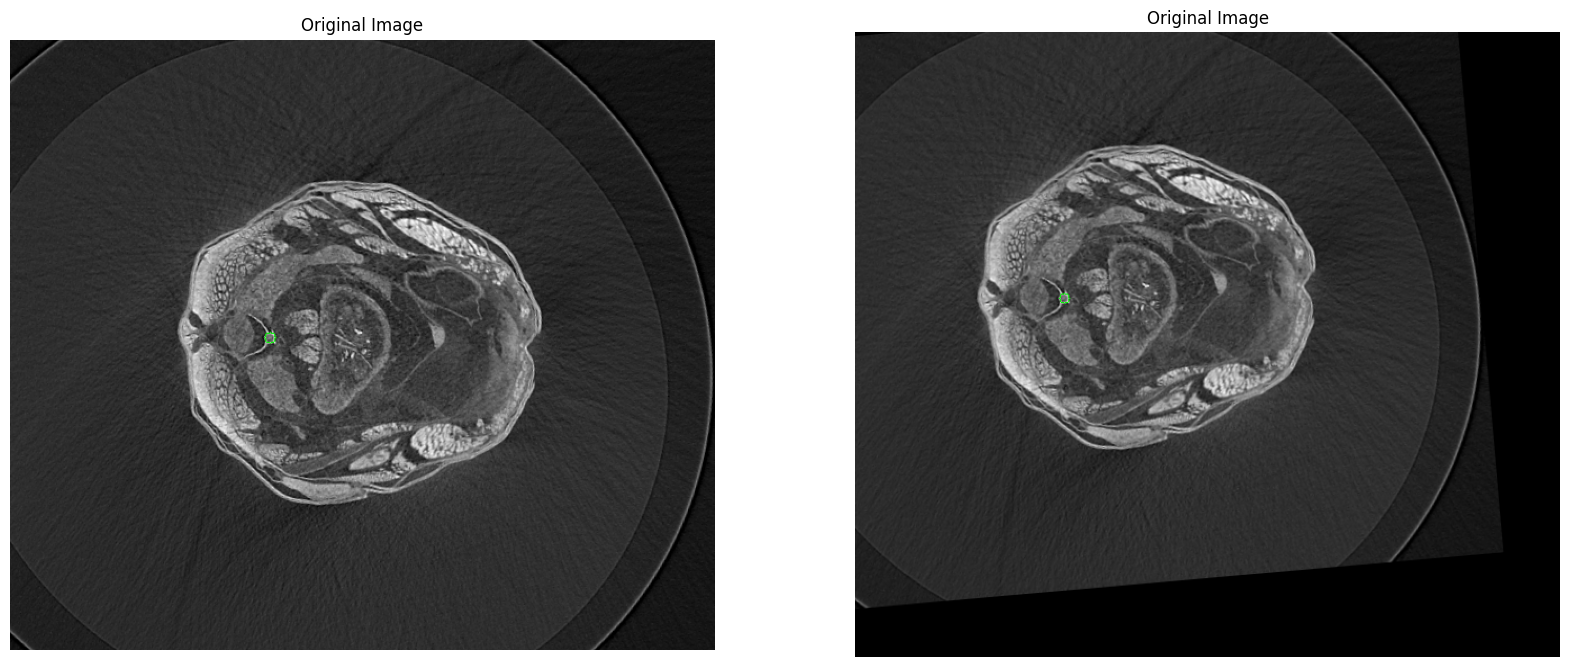

In [35]:
# translation - rotation z
rotations = torch.tensor([0, 0, np.pi/36]) # width (x) height(y) depth (z)
translations = torch.tensor([50., 50., 50.])

# image
medaka_tensor = torch.tensor(image_data, device=cuda0).float()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations)

# landmark (vert1)
p = torch.tensor([[231., 265, 600]])
rotated_p = affine_3d_idx(image_dims, rotations, translations, p)

# visualization
x, y, z = p[0].numpy().tolist()
xr, yr, zr = rotated_p[0].numpy().tolist()
sl = image_data[int(z), :, :].astype(np.uint8) # image d h w
sl_color = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_color, (round(x), round(y)), 5, (0, 255, 0))

rotated_image_np = medaka_rotated.round().cpu().numpy()
sl_rotated = rotated_image_np[round(zr), :, :].astype(np.uint8) # image d h w
sl_rotated_color = cv2.cvtColor(sl_rotated, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_rotated_color, (round(xr), round(yr)), 5, (0, 255, 0))

plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(sl_color)  # Show a slice with lm of the original image
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sl_rotated_color)  # Show a slice with lm of the rotated image
plt.title('Original Image')
plt.axis('off')

(-0.5, 660.5, 1427.5, -0.5)

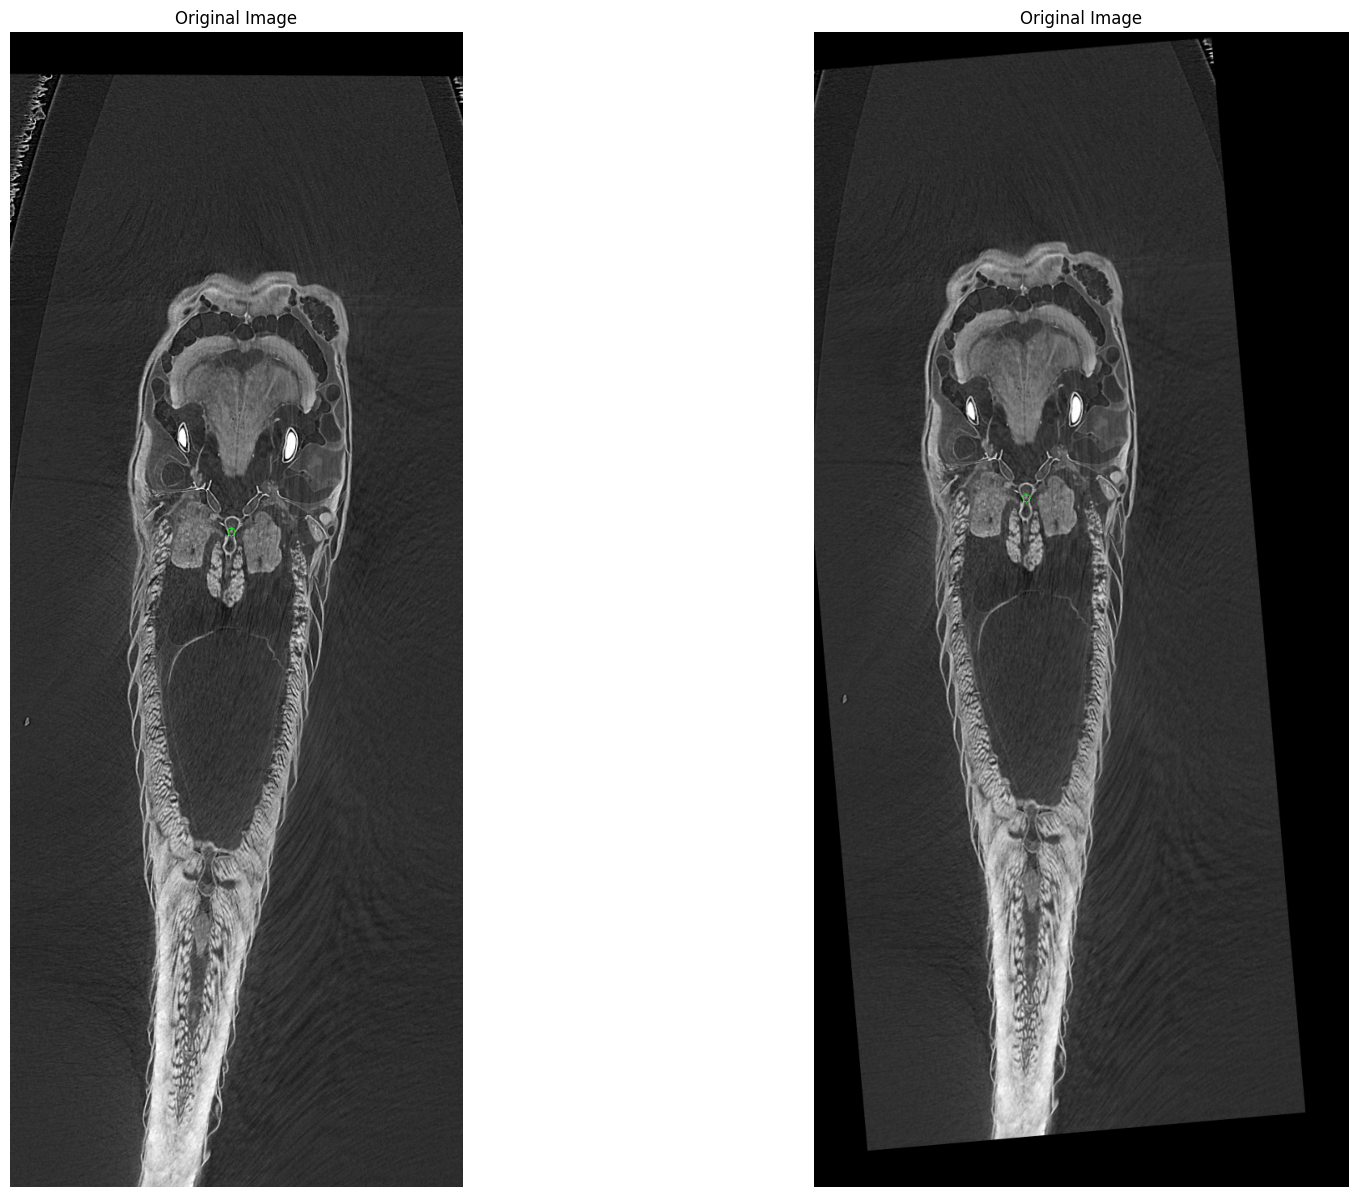

In [36]:
# translation - rotation x
rotations = torch.tensor([np.pi/36, 0, 0]) # width (x) height(y) depth (z)
translations = torch.tensor([50., 50., 50.])

# image
medaka_tensor = torch.tensor(image_data, device=cuda0).float()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations)

# landmark (Vert1)
p = torch.tensor([[231., 265, 600]]) 
rotated_p = affine_3d_idx(image_dims, rotations, translations, p)

# visualization
x, y, z = p[0].numpy().tolist()
xr, yr, zr = rotated_p[0].numpy().tolist()
sl = image_data[:, :, int(x)].astype(np.uint8) # image d h w
sl_color = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_color, (round(y), round(z)), 5, (0, 255, 0))

rotated_image_np = medaka_rotated.round().cpu().numpy()
sl_rotated = rotated_image_np[:, :, int(xr)].astype(np.uint8) # image d h w
sl_rotated_color = cv2.cvtColor(sl_rotated, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_rotated_color, (round(yr), round(zr)), 5, (0, 255, 0))

plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(sl_color)  # Show a slice with lm of the original image
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sl_rotated_color)  # Show a slice with lm of the rotated image
plt.title('Original Image')
plt.axis('off')


(-0.5, 744.5, 1435.5, -0.5)

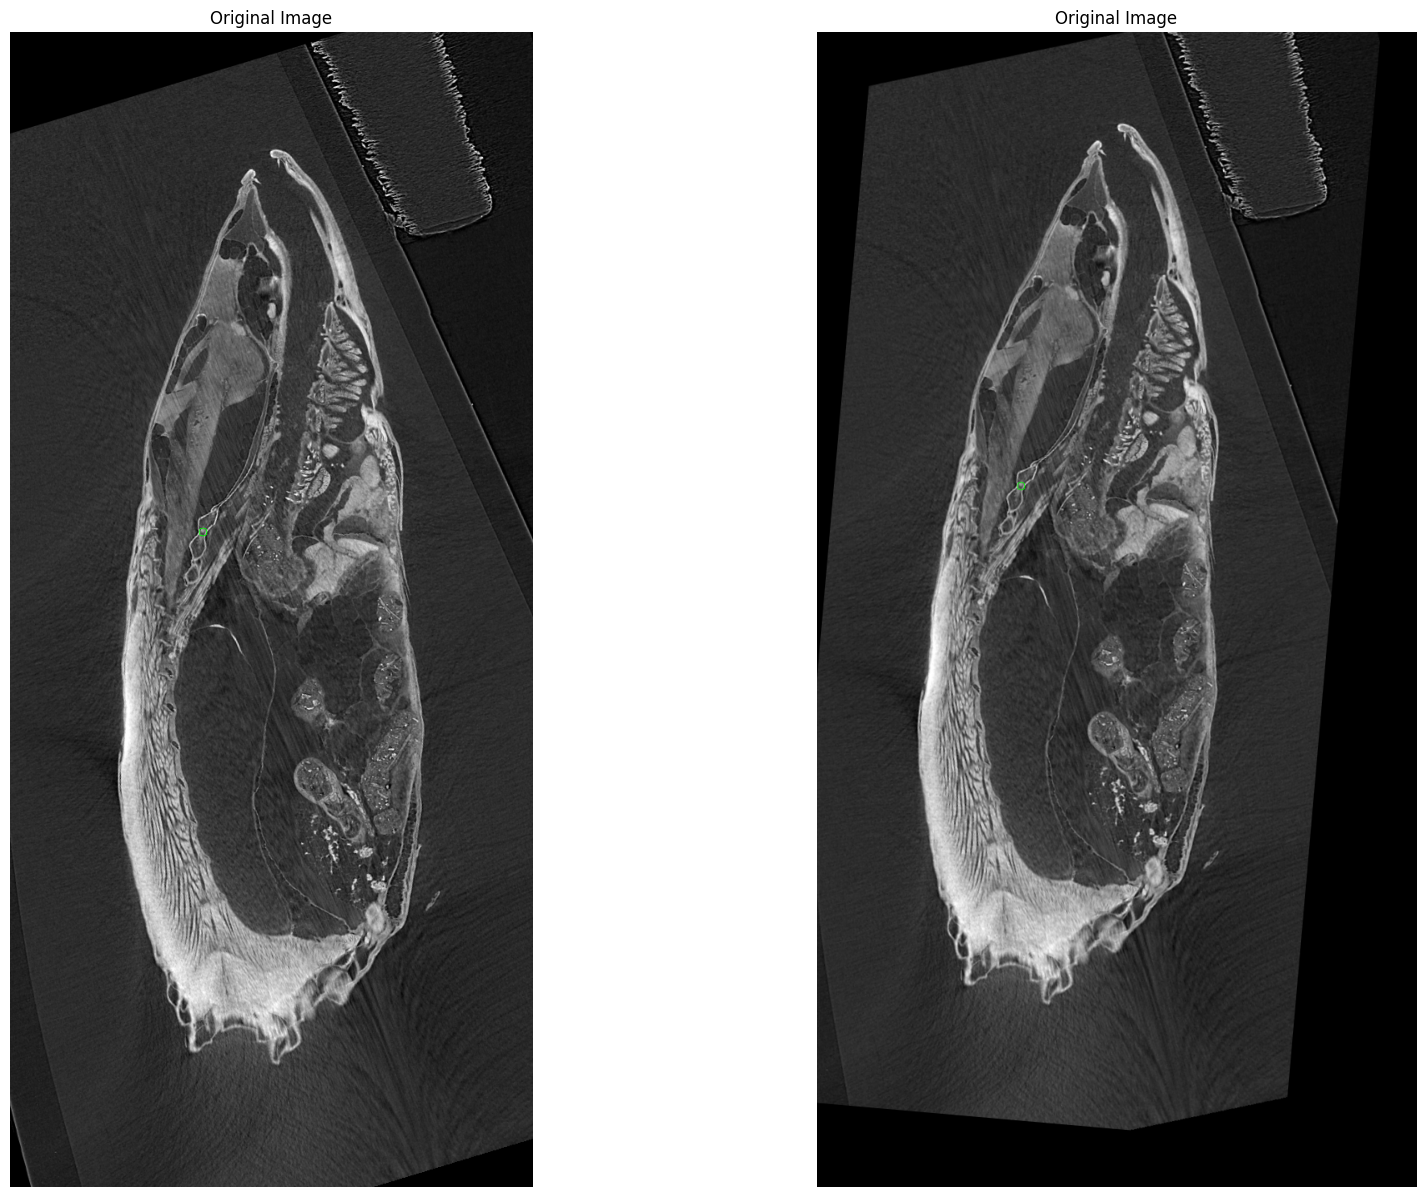

In [37]:
# translation - rotation y
rotations = torch.tensor([0, np.pi/36, 0]) # width (x) height(y) depth (z)
translations = torch.tensor([50., 50., 50.])

# image
medaka_tensor = torch.tensor(image_data, device=cuda0).float()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations)

# landmark
p = torch.tensor([[231., 265, 600]])
rotated_p = affine_3d_idx(image_dims, rotations, translations, p)

# visualization
x, y, z = p[0].numpy().tolist()
xr, yr, zr = rotated_p[0].numpy().tolist()
sl = image_data[:, int(y), :].astype(np.uint8) # image d h w
sl_color = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_color, (round(x), round(z)), 5, (0, 255, 0))

rotated_image_np = medaka_rotated.round().cpu().numpy()
sl_rotated = rotated_image_np[:, int(yr), :].astype(np.uint8) # image d h w
sl_rotated_color = cv2.cvtColor(sl_rotated, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_rotated_color, (round(xr), round(zr)), 5, (0, 255, 0))

plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(sl_color)  # Show a slice with lm of the original image
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sl_rotated_color)  # Show a slice with lm of the rotated image
plt.title('Original Image')
plt.axis('off')